# Calcium and Excitation-Contraction Coupling in the Heart

Eisner, Caldwell, Kistamas, Trafford (2017) Circulation Research

https://doi.org/10.1161/CIRCRESAHA.117.310230

In this notebook I try to reproduce the first example given in this paper:

> In the steady state, on each cardiac cycle, the amount of Ca entering the cell must equal that pumped out. If not, the cell would either gain or lose Ca. Imbalances between Ca entry and exit can only occur transiently and then result in changes of the amplitude of the Ca transient and thence contractility. One well-known example is the effect of changing frequency or pausing stimulation. If stimulation is stopped in ventricular muscle from most nonrodent species, Ca leaks out of the SR, SR content decreases, and therefore the first stimulus results in a small Ca transient and contraction. Because the Ca transient is small, less Ca is pumped out of the cell than enters and the cell is not in Ca flux balance. This results in an increase of SR Ca content until the Ca transient increases sufficiently that the Ca efflux now balances influx and the cell is back in a steady state. In the steady state, however, influx and efflux must be equal.    

## Model
A novel computational model of the human ventricular action potential and Ca transient  
Eleonora Grandi, Francesco S. Pasqualini, Donald M. Bers,  
2010, Journal of Molecular and Cellular Cardiology, volume 48, 112-121.  
   
https://doi.org/10.1016/j.yjmcc.2009.09.019

### Model calcium and subspaces
> For example, the increase in [Ca] upon Ca-induced Ca release appears to be higher just under the sarcolemma than in bulk cytosol, and this higher [Ca] is detected by Na–Ca exchanger (NCX) [13]. Here we have taken advantage of the rabbit ECC model developed by Shannon et al. [2], which includes this additional subsarcolemmal compartment (SL) and provides a detailed description of Ca handling.

From Shannon (https://doi.org/10.1529/biophysj.104.047449)

### Model compartments
1. Subsarcolemmal: Just below _all_ channels
2. Junctional: The dyadic cleft!

## Step 1: Load the model, have a look



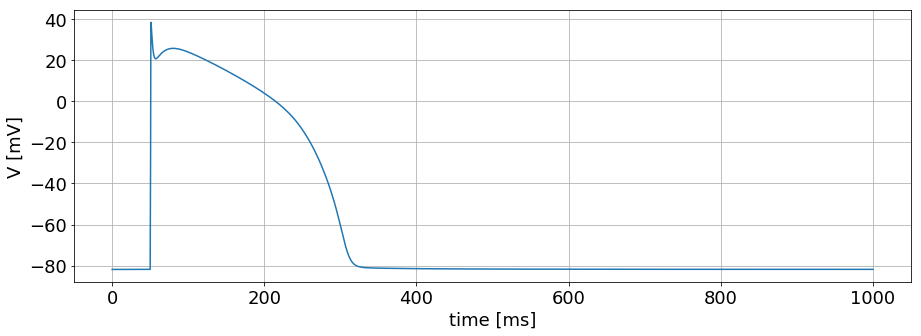

In [15]:
# Load matplotlib, tell it to make nicer plots
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (15,5), 'font.size': 18})
import matplotlib.pyplot as pl

# Load myokit
import myokit

# Load a model from a file
m = myokit.load_model('grandi-2010.mmt')

# Create a pacing protocol
cl = 1000 # Cycle length 1000ms
p = myokit.pacing.blocktrain(cl, 0.5, offset=50) # 0.5ms duration, offset 50ms, repeating!

# Run a simple simulation
s = myokit.Simulation(m, p)
d = s.run(cl)

# Plot the results
pl.figure()
pl.xlabel('time [ms]')
pl.ylabel('V [mV]')
pl.plot(d.time(), d['membrane.V'])
pl.show()

## Step 2: Check if the model is in steady state

First thing to do is always pace to steady state. To check if that's working, we first look at the slowest moving variables in the model: the ionic concentrations:

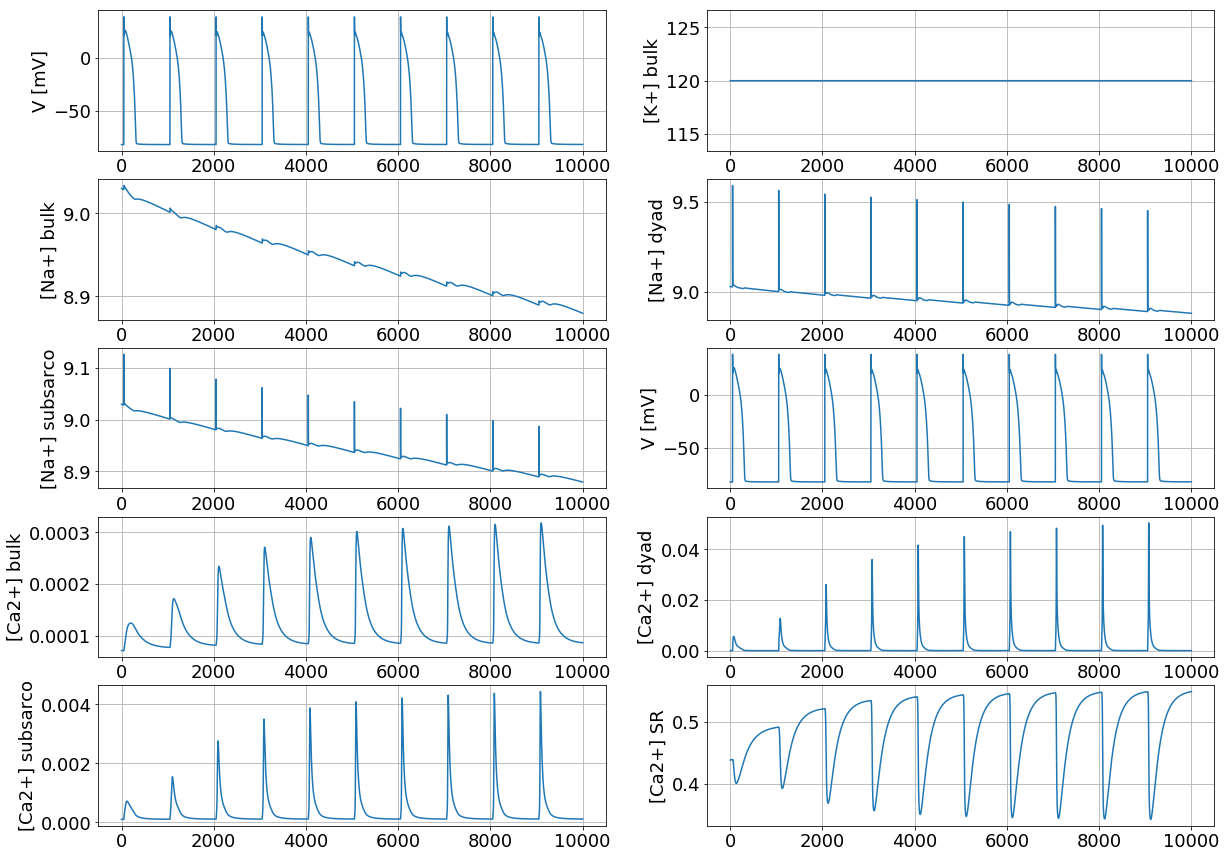

In [16]:
def plot_concentrations(d):
    """ Plot all dynamic concentrations in the grandi model """
    
    pl.figure(figsize=(20,15))
    
    # Top left: Vm
    pl.subplot(5,2,1)
    pl.plot(d.time(), d['membrane.V'])
    pl.ylabel('V [mV]')
    
    # Potassium
    pl.subplot(5,2,2)
    pl.plot(d.time(), d['potassium.K_i'])
    pl.ylabel('[K+] bulk')
    
    # Sodium in various spaces
    pl.subplot(5,2,3)    
    pl.plot(d.time(), d['sodium.Na_i'])
    pl.ylabel('[Na+] bulk')
    
    pl.subplot(5,2,4)    
    pl.plot(d.time(), d['sodium.Na_j'])
    pl.ylabel('[Na+] dyad')
    
    pl.subplot(5,2,5)    
    pl.plot(d.time(), d['sodium.Na_sl'])
    pl.ylabel('[Na+] subsarco')
    
    # Top right: Vm again
    pl.subplot(5,2,6)
    pl.plot(d.time(), d['membrane.V'])
    pl.ylabel('V [mV]')
    
    # Calcium in various spaces
    pl.subplot(5,2,7)
    pl.plot(d.time(), d['calcium.Ca_i'])
    pl.ylabel('[Ca2+] bulk')
    
    pl.subplot(5,2,8)
    pl.plot(d.time(), d['calcium.Ca_j'])
    pl.ylabel('[Ca2+] dyad')
    
    pl.subplot(5,2,9)
    pl.plot(d.time(), d['calcium.Ca_sl'])
    pl.ylabel('[Ca2+] subsarco')
    
    pl.subplot(5,2,10)
    pl.plot(d.time(), d['bufca3.Ca_sr'])
    pl.ylabel('[Ca2+] SR')
    pl.show()

# Show initial drift
s.reset()
plot_concentrations(s.run(cl * 10))

Another way to check the steady state is to look at the total transmembrane calcium current, and check if what comes in goes out again.

$I_{Ca,total} = I_{CaL} - 2 I_{NaCa} + I_{Ca,background} + I_{Ca,sarcolemmal pump}$

The first term here, $I_{Ca,total}$ represents the total charge carried by calcium currents through the membrane (using the convention "negative current (positive) carries charge into the cell")

In 'forward mode', NCX ($I_{NaCa}$) carries $3 Na^+$ into the cell, and $1 Ca^{2+}$ out, resulting in a net increase of +1
So for every charge carried into the cell by NCX, it _extrudes_ $1 Ca^{2+}$: In other words, its contribution to $I_{Ca,total}$ is $-$ (because Ca goes against the current) $2$ (because Ca has 2 charges) times $I_{NaCa}$

The plot below shows $I_{Ca,total}$, plotted for 10 beats (from the 'bad' initial conditions). To compare the beats, we "fold" them over each other:

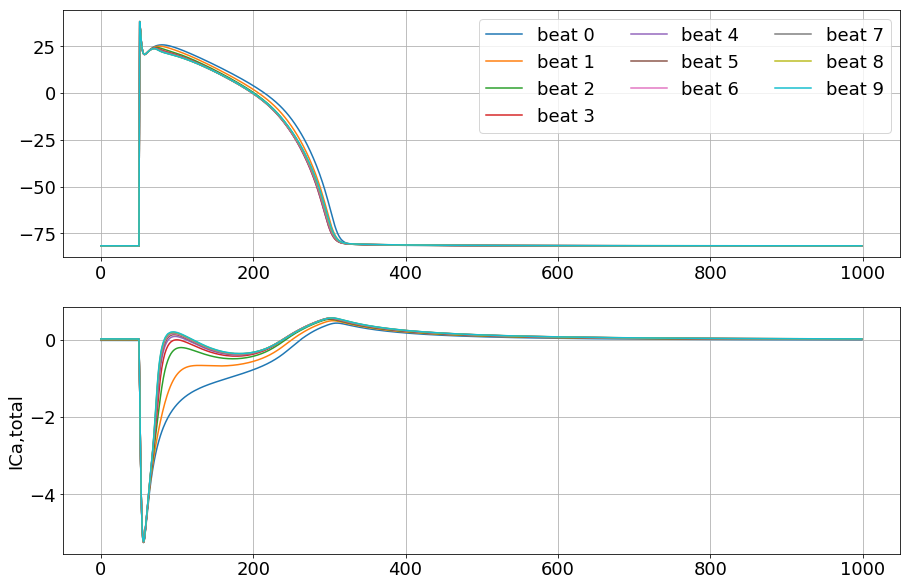

In [17]:
# Run quick simulation
s.reset()
d = s.run(cl * 10, log_interval=1).fold(cl)

# Check calcium influx/efflux balance
pl.figure(figsize=(15,10))
pl.subplot(2,1,1)
for i in xrange(10):
    pl.plot(d['engine.time'], d['membrane.V', i], label='beat ' + str(i))
pl.legend(ncol=3)
pl.subplot(2,1,2)
pl.ylabel('ICa,total')
for i in xrange(10):
    pl.plot(d['engine.time'], d['membrane.I_Ca_tot', i])
pl.show()

This shows us that the total calcium that passes the outer membrane changes over time, and ends up close to zero in the diastolic phase

To see the total influx/efflux per beat, we can integrate this signal, to get:

$Q_{Ca} = \int I_{Ca,total}$

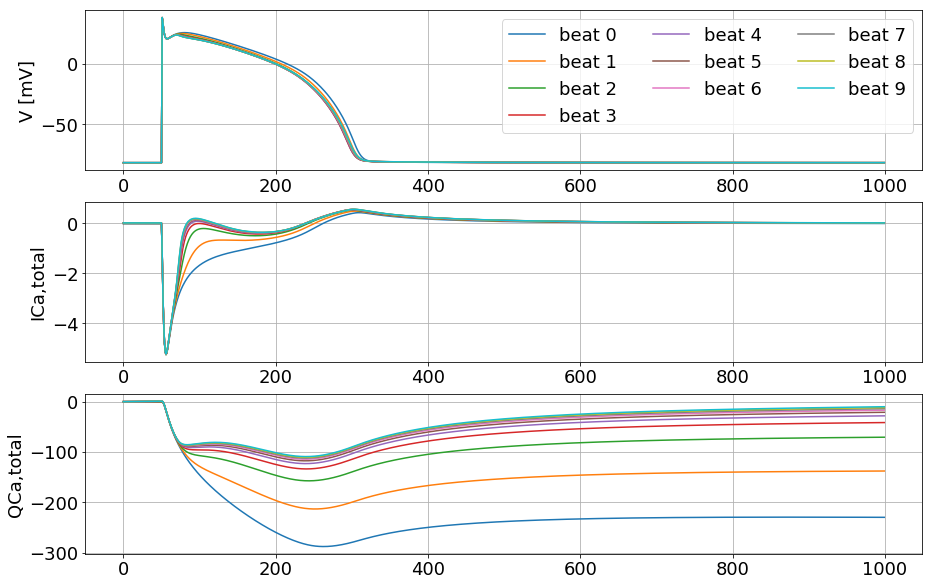

In [18]:
def plot_flux_balance(d):
    d = d.fold(cl)
    pl.figure(figsize=(15,10))
    
    pl.subplot(3,1,1)
    pl.ylabel('V [mV]')
    for i in xrange(10):
        pl.plot(d['engine.time'], d['membrane.V', i], label='beat ' + str(i))
    pl.legend(ncol=3)
    
    pl.subplot(3,1,2)
    pl.ylabel('ICa,total')
    for i in xrange(10):
        pl.plot(d['engine.time'], d['membrane.I_Ca_tot', i])
    
    pl.subplot(3,1,3)
    pl.ylabel('QCa,total')
    for i in xrange(10):
        pl.plot(d['engine.time'], d.integrate('membrane.I_Ca_tot', i))
    pl.show()

# Run quick simulation
s.reset()
d = s.run(cl * 10, log_interval=1)
plot_flux_balance(d)

This clearly shows the cell isn't in steady state, as the sum of influx and efflux does not equal zero at the end of every beat (although it does get better every beat).

If the cell is in steady state, the total charge carried past the membrane should first get negative (corresponding to a net influx of calcium) and then become less negative (as the efflux starts) until it is zero (balance)

## Step 3: Pace to steady state

In [19]:
# Restart the simulation
s.reset()

# Pace for 500 beats
s.run(1000 * 500, log=myokit.LOG_NONE)

# Save this state for later
steady_state = s.state()

print('Done!')

Done!


Now look at the concentrations again:

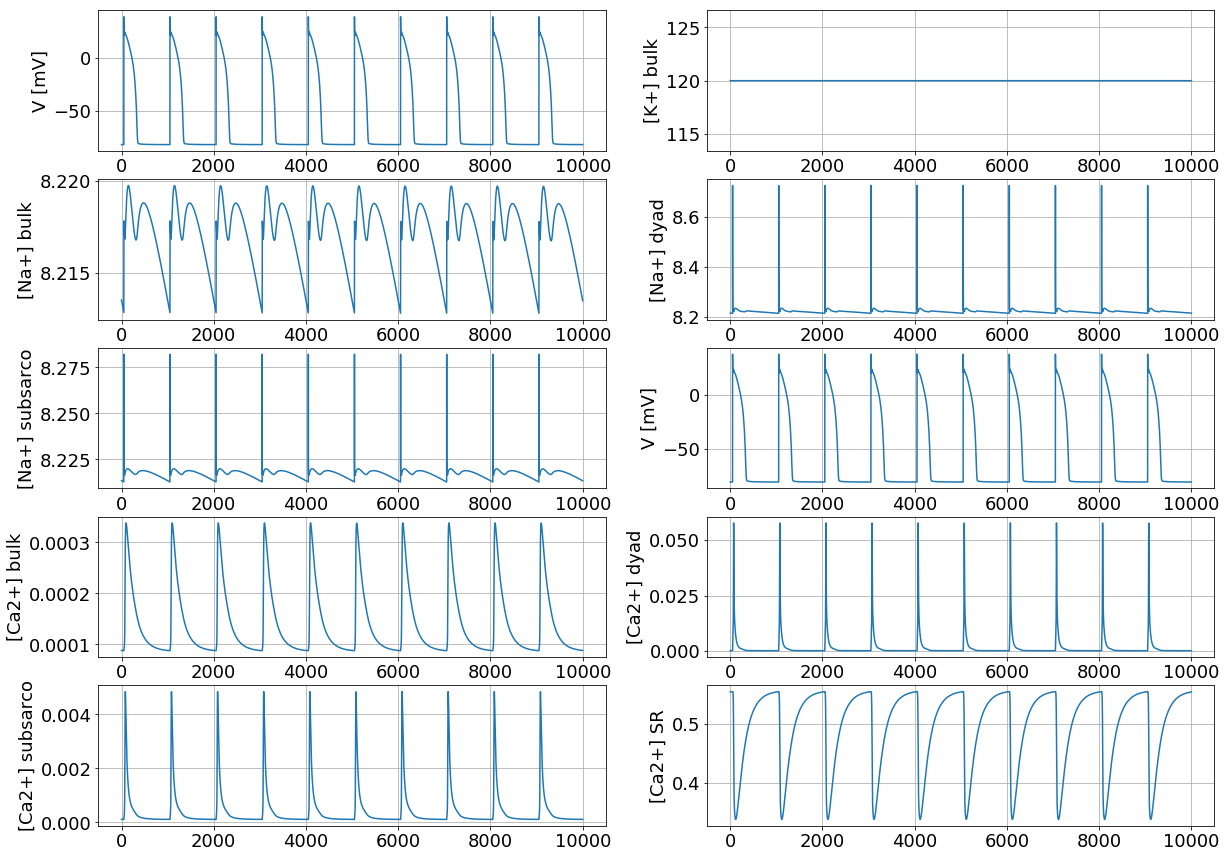

In [20]:
s.reset()
s.set_state(steady_state)
d = s.run(cl * 10, log_interval=1)
plot_concentrations(d)

And the flux balance:

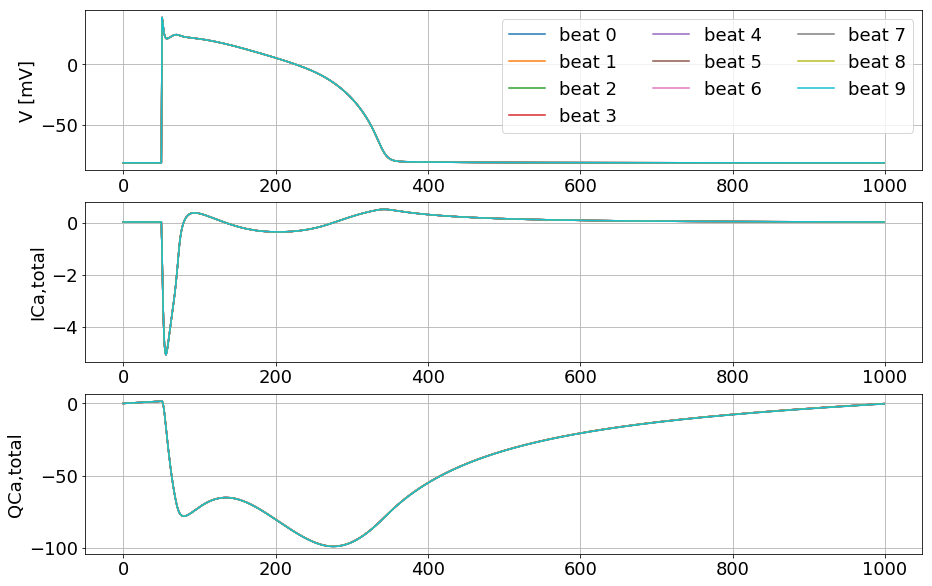

In [21]:
plot_flux_balance(d)

## Step 4: Start the actual experiment!

> If stimulation is stopped in ventricular muscle from most nonrodent species, Ca leaks out of the SR

Ok! So let's plot a few beats (from steady state), then stop, then start again

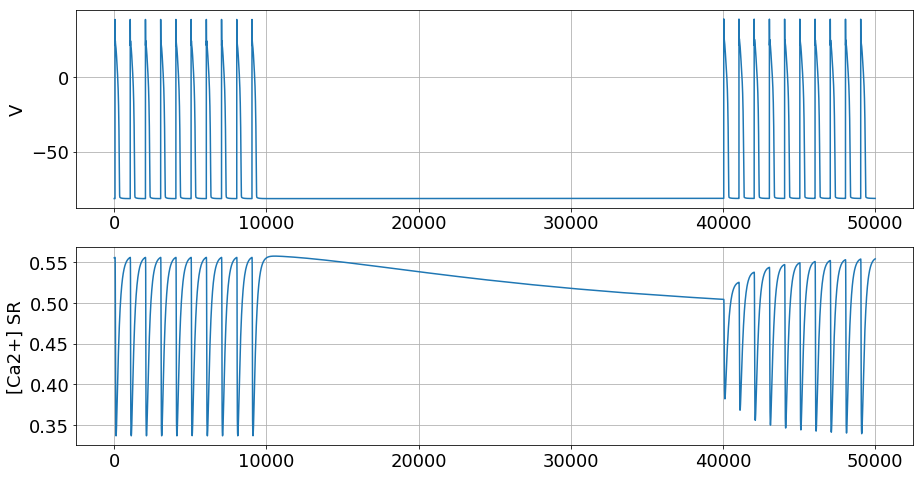

In [22]:
# Reset to steady state
s.reset()
s.set_state(steady_state)

# Run for 10 beats with a protocol
s.set_protocol(p)
d = s.run(10*cl)

# Run for 30 beats without a protocol
s.set_protocol(None)
d = s.run(30*cl, log=d)

# Run for 10 beats with a protocol
s.set_protocol(p)
d = s.run(10*cl, log=d)
d = d.npview()

# Have a look at the calcium in the SR
pl.figure(figsize=(15, 8))
pl.subplot(2,1,1)
pl.ylabel('V')
pl.plot(d['engine.time'], d['membrane.V'])
pl.subplot(2,1,2)
pl.plot(d['engine.time'], d['bufca3.Ca_sr'])
pl.ylabel('[Ca2+] SR')
pl.show()

It works! Calcium is leaking out of the SR, and recovers when we start pacing again

Next, the paper says:
> SR content decreases, and therefore the first stimulus results in a small Ca transient and contraction.

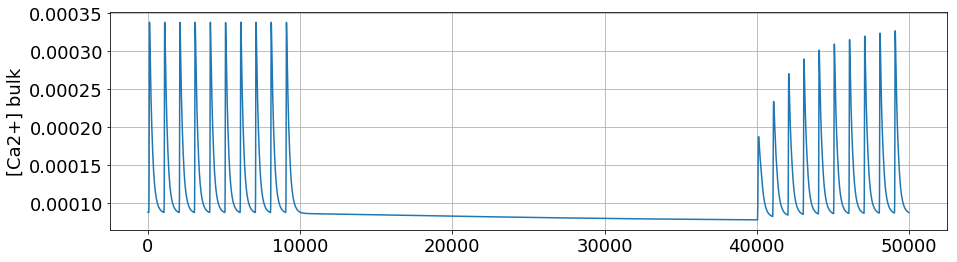

In [23]:
pl.figure(figsize=(15, 4))
pl.ylabel('[Ca2+] bulk')
pl.plot(d['engine.time'], d['calcium.Ca_i'])
pl.show()

Yup, we see that too!

## Step 5: Flux balance after restarting pacing
Next, the paper says:
> Because the Ca transient is small, less Ca is pumped out of the cell than enters and the cell is not in Ca flux balance. This results in an increase of SR Ca content until the Ca transient increases sufficiently that the Ca efflux now balances influx and the cell is back in a steady state. In the steady state, however, influx and efflux must be equal.

So let's analyse the flux balance after we restart our pacing (at t = 40000)

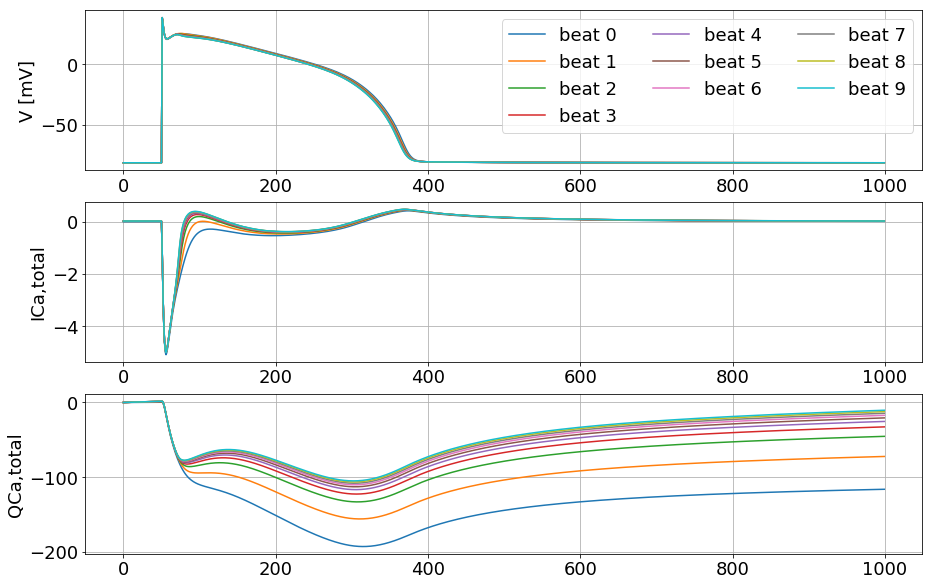

In [60]:
# Resample to get evenly spaced points in time
d2 = d.regularize(1)

# Chop off the bit before 40000
d2 = d2.trim_left(40000, adjust=True)

# Plot flux balance
plot_flux_balance(d2)

## Step 6: How is flux balance achieved?

According to the paper, a flux imbalance is restored in three steps:

1. bulk Ca determines SR Ca
    1. If influx > efflux, bulk Ca increases and therefore SR calcium increases
    2. If efflux > influx, bulk Ca decreases and therefore SR calcium decreases
2. Ca-induced-Ca release (seen in the Ca transient) is a _steep function of SR Calcium content_
3. Increasing the transient increases efflux, decreases influx, because
    1. Ca presence increases NCX action
    2. Ca presence increases ICaL inactivation


### 6.1: Bulk Ca determines SR Ca

Let's have a look and see how bulk and SR calcium correlate in this model:

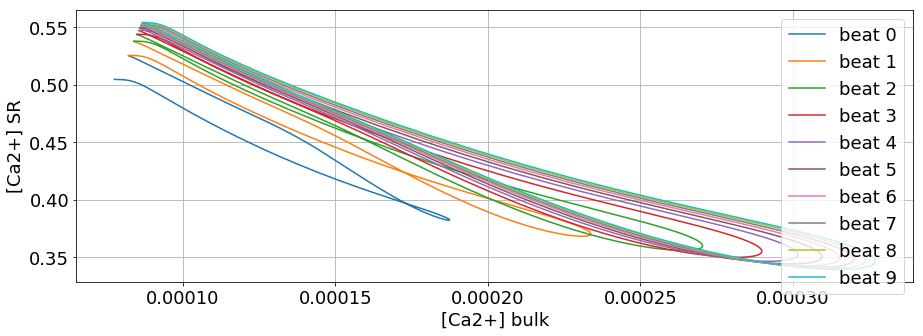

In [61]:
d3 = d2.fold(cl)

pl.figure()
pl.xlabel('[Ca2+] bulk')
pl.ylabel('[Ca2+] SR')
for i in xrange(10):
    pl.plot(d3['calcium.Ca_i', i], d3['bufca3.Ca_sr', i], label='beat ' + str(i))
pl.legend()
pl.show()

This shows that, while SR and bulk Ca2+ have an interesting relationship, beat-per-beat they do go up together!

### 6.2: Ca transient is a steep function of SR content

To see this, let's look at the calcium in the SR before every upstroke, and compare it with the peak bulk Ca2+


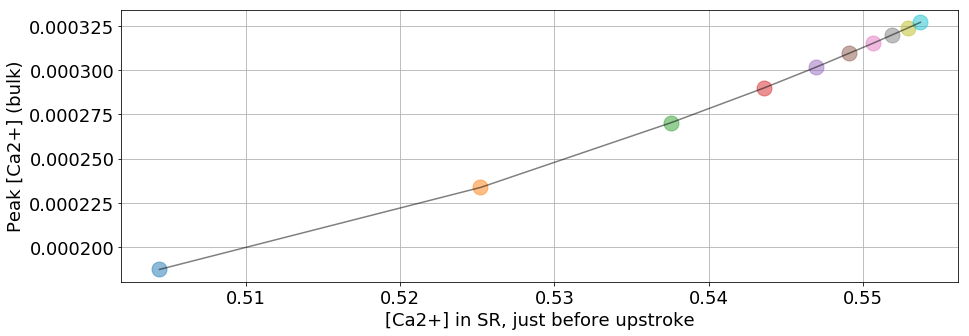

In [62]:
d3 = d2.fold(cl)

calcium_sr = []
peak_ca = []
for i in xrange(10):
    calcium_sr.append(d3['bufca3.Ca_sr', i][49]) # Ca_SR at 49ms, just before stimulus at 50ms!
    peak_ca.append(max(d3['calcium.Ca_i', i]))

pl.figure()
pl.xlabel('[Ca2+] in SR, just before upstroke')
pl.ylabel('Peak [Ca2+] (bulk)')
for i in xrange(10):
    pl.plot(calcium_sr[i], peak_ca[i], 'o', alpha=0.5, ms=15)
pl.plot(calcium_sr, peak_ca, color='k', alpha=0.5)
pl.show()

We can do the same for the transient in the dyad:

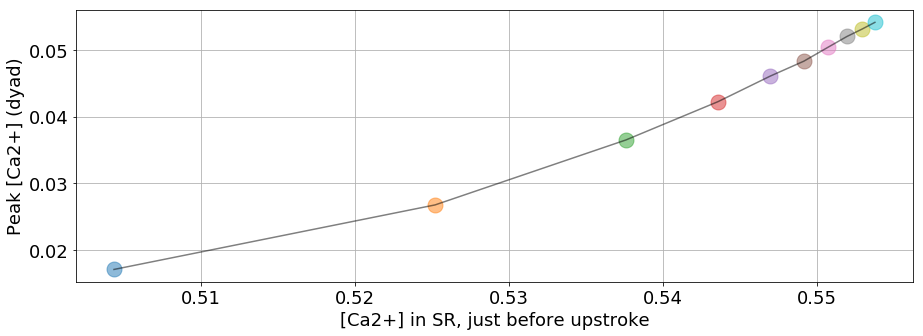

In [63]:
d3 = d2.fold(cl)

calcium_sr = []
peak_ca = []
for i in xrange(10):
    calcium_sr.append(d3['bufca3.Ca_sr', i][49]) # Ca_SR at 49ms, just before stimulus at 50ms!
    peak_ca.append(max(d3['calcium.Ca_j', i]))

pl.figure()
pl.xlabel('[Ca2+] in SR, just before upstroke')
pl.ylabel('Peak [Ca2+] (dyad)')
for i in xrange(10):
    pl.plot(calcium_sr[i], peak_ca[i], 'o', alpha=0.5, ms=15)
pl.plot(calcium_sr, peak_ca, color='k', alpha=0.5)
pl.show()

### 6.3A Ca presence increases NCX action

To look at the relationship between Calcium and NCX, let's plot the NCX current (into the subsarcolemmal space) against the _bulk_ Ca

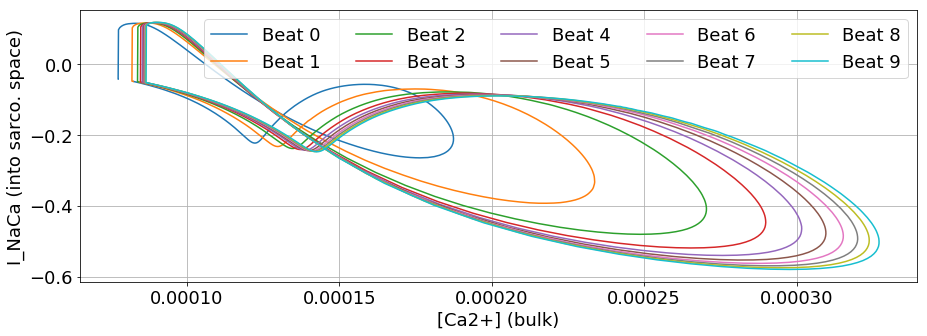

In [64]:
d3 = d2.fold(cl)

pl.figure()
pl.xlabel('[Ca2+] (bulk)')
pl.ylabel('I_NaCa (into sarco. space)')
for i in xrange(10):
    pl.plot(d3['calcium.Ca_i', i], d3['incx.I_ncx_sl', i], label='Beat ' + str(i))
pl.legend(ncol=5)
pl.show()

Again, they seem to increase together (as [Ca2+] in the bulk grows, the amplitude of NCX grows larger (more negative))

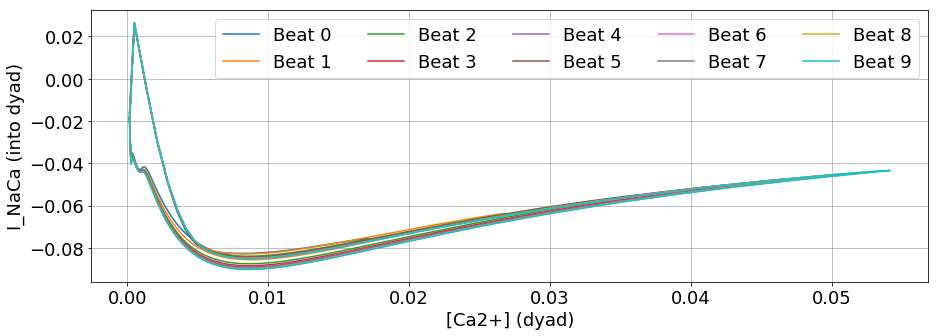

In [65]:
d3 = d2.fold(cl)

pl.figure()
pl.xlabel('[Ca2+] (dyad)')
pl.ylabel('I_NaCa (into dyad)')
for i in xrange(10):
    pl.plot(d3['calcium.Ca_j', i], d3['incx.I_ncx_junc', i], label='Beat ' + str(i))
pl.legend(ncol=5)
pl.show()

Here the relationship is much harder to see!

### 6.3B: Ca presence increases ICaL inactivation

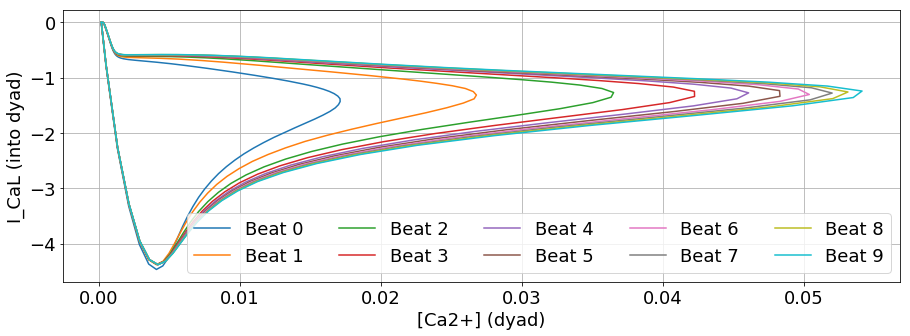

In [66]:
d3 = d2.fold(cl)

pl.figure()
pl.xlabel('[Ca2+] (dyad)')
pl.ylabel('I_CaL (into dyad)')
for i in xrange(10):
    pl.plot(d3['calcium.Ca_j', i], d3['ical.I_Ca_junc', i], label='Beat ' + str(i))
pl.legend(ncol=5)
pl.show()

This is much harder to see! The maximum and minimum of the current seem to stay the same. Let's look at the raw traces

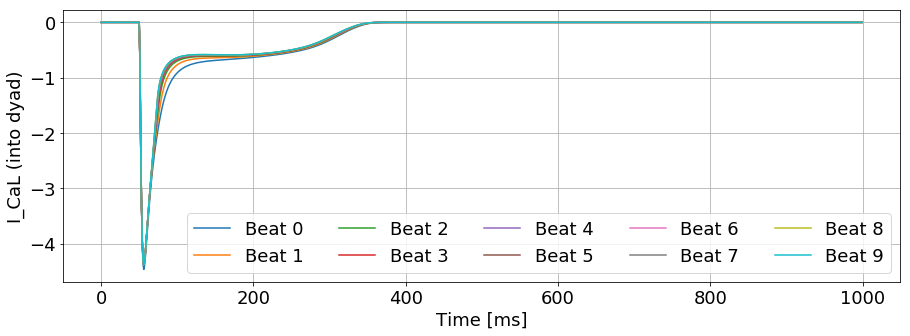

In [67]:
d3 = d2.fold(cl)

pl.figure()
pl.xlabel('Time [ms]')
pl.ylabel('I_CaL (into dyad)')
for i in xrange(10):
    pl.plot(d3['engine.time'], d3['ical.I_Ca_junc', i], label='Beat ' + str(i))
pl.legend(ncol=5)
pl.show()

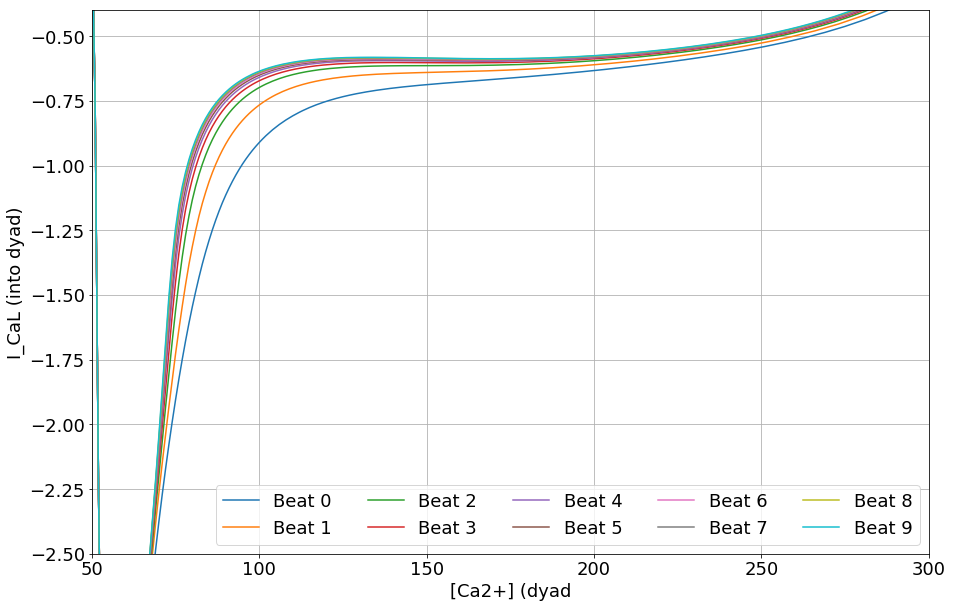

In [70]:
d3 = d2.fold(cl)

pl.figure(figsize=(15, 10))
pl.xlabel('[Ca2+] (dyad')
pl.ylabel('I_CaL (into dyad)')
for i in xrange(10):
    pl.plot(d3['engine.time'], d3['ical.I_Ca_junc', i], label='Beat ' + str(i))
pl.xlim(50, 300)
pl.ylim(-2.5, -0.4)
pl.legend(ncol=5)
pl.show()

That does look like a decrease in activation, but it's not huge in this model!

We can check out the influence it has on the total calcium moved by integrating the current (to get the moved charge per beat)

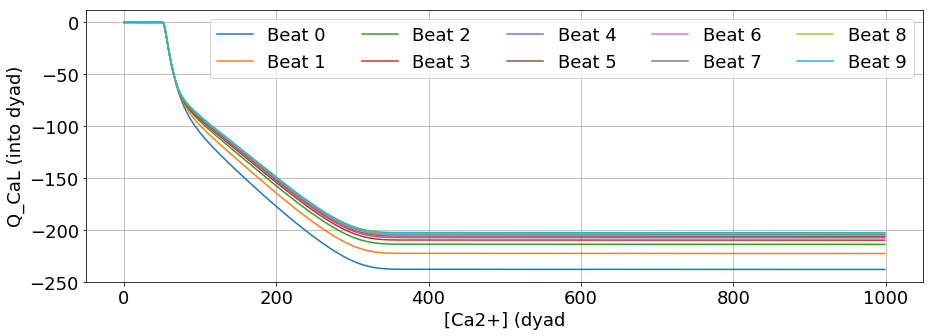

In [73]:
d3 = d2.fold(cl)

pl.figure()
pl.xlabel('[Ca2+] (dyad')
pl.ylabel('Q_CaL (into dyad)')
for i in xrange(10):
    pl.plot(d3['engine.time'], d3.integrate('ical.I_Ca_junc', i), label='Beat ' + str(i))
pl.legend(ncol=5)
pl.show()

Now we can see that this 'small' change actually has a large effect (reducing the current by almost 20%)